In [1]:
import glob
import pandas as pd
# import numpy as np
from pathlib import Path
# from typing import List
import requests
from tqdm.notebook import tqdm
from collections import Counter, defaultdict
from xml.etree import ElementTree
from matplotlib import pyplot as plt
import time

In [2]:
def krnnt2(text):
    response = requests.post("http://localhost:9200", data=text.replace("\n", " ").encode("utf-8"))
    return response.content.decode("utf-8")

# files_content["tagged"] = [krnnt2(text.lower()) for text in tqdm(files_content["text"], total=1179)]

# files_content.to_csv("files_tagged_normal.csv")

In [3]:
files = [f for f in glob.glob('../ustawy/*')]

def read_file(filename):
    with open(filename, encoding='UTF-8') as f:
        text = f.read()
        return text


files_content = pd.DataFrame({
    "id": [Path(filename).stem for filename in files],
    "text": [read_file(filename) for filename in files]
})

# files_content["tagged"] = pd.read_csv("files_tagged.csv")["tagged"]
files_content["tagged"] = pd.read_csv("files_tagged_normal.csv")["tagged"]

len(files_content)

1179

In [4]:
files_content.head()

,id,text,tagged
0,1993_599,"\n\n\n\nDz.U. z 1993 r. Nr 129, poz. 599 \n ...",Dz\tnone\n\tdziennik\tbrev:pun\tdisamb\n.\tnon...
1,1993_602,"\n\n\n\nDz.U. z 1993 r. Nr 129, poz. 602 \n ...",Dz\tnone\n\tdziennik\tbrev:pun\tdisamb\n.\tnon...
2,1993_645,"\n\n\n\nDz.U. z 1993 r. Nr 134, poz. 645\n ...",Dz\tnone\n\tdziennik\tbrev:pun\tdisamb\n.\tnon...
3,1993_646,"\n\n\n\nDz.U. z 1993 r. Nr 134, poz. 646\n ...",Dz\tnone\n\tdziennik\tbrev:pun\tdisamb\n.\tnon...
4,1994_150,"\n\n\n\nDz.U. z 1994 r. Nr 40, poz. 150\n ...",Dz\tnone\n\tdziennik\tbrev:pun\tdisamb\n.\tnon...


# 4. Sort bills according to their size and take top 50 (largest) bills.

In [5]:
files_content["length"] = [len(text) for text in files_content["text"]]
files_content = files_content.sort_values(by='length', ascending=False)
files_content = files_content.head(50)

In [6]:
files_content[:5]

,id,text,tagged,length
591,2000_696,"\n\n\n\nDz.U. z 1998 r. Nr 106, poz. 668\n ...",Dz\tnone\n\tdziennik\tbrev:pun\tdisamb\n.\tnon...,560054
754,2001_627,"\n\n\n\nDz.U. z 2001 r. Nr 62, poz. 627\n ...",Dz\tnone\n\tdziennik\tbrev:pun\tdisamb\n.\tnon...,397912
174,1996_465,"\n\n\n\nDz.U. z 2000 r. Nr 94, poz. 1037\n ...",Dz\tnone\n\tdziennik\tbrev:pun\tdisamb\n.\tnon...,396433
296,1997_555,"\n\n\n\nDz.U. z 1997 r. Nr 89, poz. 555 \n ...",Dz\tnone\n\tdziennik\tbrev:pun\tdisamb\n.\tnon...,377867
831,2002_1689,\n\n\nTekst ustawy\nustalony ostatecznie po ro...,Tekst\tnone\n\ttekst\tsubst:sg:nom:m3\tdisamb\...,335096


# 5. Use the lemmatized and sentence split documents (from ex. 5) to identify the expressions that consist of consecutive words starting with a capital letter (you will have to look at the inflected form of the word to check its capitalization) that do not occupy the first position in a sentence. 
E.g. the sentence:

```Wczoraj w Krakowie miało miejsce spotkanie prezydentów Polski i Stanów Zjednoczonych.```

should yield the following entries: Kraków, Polska, Stan Zjednoczony.

In [7]:
text = files_content['text']
tagged = files_content['tagged']

In [8]:
class Token:
    word: str
    lemma: str
    category: str

    def __repr__(self):
        return f"{self.word} ({self.lemma}:{self.category})"


In [9]:
# zdania są dzielone jednym wierszem pustym: 
# plain - sentences divided by one empty line, documents by two empty lines
'''
Plan:
lecimy po kazym dokumencie
dzielimy wszystko po '\n'
zapisujemy do tablicy kolejne słowa
jak trafimy na pusty wiersz to zapisujemy to jako sentence i czyscimy tablice słów
jak mamy tablicę ze zdaniami to idziemy po kazdym zdaniu
idziemy po kazdym słowie w zdaniu
jezeli słowo jest pierwsze w zdaniu to je pomijamy
'''

"\nPlan:\nlecimy po kazym dokumencie\ndzielimy wszystko po '\n'\nzapisujemy do tablicy kolejne słowa\njak trafimy na pusty wiersz to zapisujemy to jako sentence i czyscimy tablice słów\njak mamy tablicę ze zdaniami to idziemy po kazdym zdaniu\nidziemy po kazdym słowie w zdaniu\njezeli słowo jest pierwsze w zdaniu to je pomijamy\n"

In [10]:
sentences = []
for id, document in tqdm(enumerate(tagged), total=50):
    lines = document.split("\n")

    words = []

    for i, line in enumerate(lines):
        if line == "":
            if len(words) > 0:
                sentences.append(words)
                words = []
        elif line.startswith("\t"):
            prev_line = lines[i - 1]
            token = Token()
            token.word = prev_line.split("\t")[0]
            token.lemma = line.split("\t")[1]
            # token.lemma = line.split("\t")[1].lower()
            token.category = line.split("\t")[2].split(":")[0]
            words.append(token)

In [11]:
sentences[90]

[Jeżeli (jeżeli:comp),
 wnioskodawca (wnioskodawca:subst),
 zamieszkuje (zamieszkiwać:fin),
 za (za:prep),
 granicą (granica:subst),
 , (,:interp),
 podanie (podanie:subst),
 składa (składać:fin),
 się (się:qub),
 za (za:prep),
 pośrednictwem (pośrednictwo:subst),
 konsula (konsul:subst),
 Rzeczypospolitej (Rzeczpospolita:subst),
 Polskiej (polski:adj),
 . (.:interp)]

In [12]:
def search_for_names(sentences):
    def search_for_capitals(sentence):
        first = True
        name_words = []
        
        for token in sentence:
            if token.word[0].isupper():
                name_words.append(token.lemma)
            else:
                if not first and len(name_words) > 0:
                    yield " ".join(name_words)
                first = False
                name_words = []
                
    return [
        entity
        for sentence in sentences
        for entity in search_for_capitals(sentence)
    ]

In [13]:
names_classic = search_for_names(sentences)

In [14]:
names_classic[:10]

['ustawa',
 'ustawa',
 'artykuł',
 'dziennik',
 'ustawa',
 'artykuł',
 'dziennik',
 'ustawa',
 'numer',
 'artykuł']

# 6. Compute the frequency of each identified expression and print 50 results with the largest number of occurrences.

In [15]:
pd.set_option('display.max_rows', None)

top_50_names_classic = Counter(names_classic).most_common(50)
pd.DataFrame.from_records(top_50_names_classic, columns=["names_classic", "count"], index="names_classic")

,count
names_classic,
numer,4583
artykuł,1840
dziennik,1599
ustawa,1515
Rzeczpospolita polski,601
kodeks,499
policja,454
skarb państwo,389
prawo,330


# 7. Apply the NER algorithm to identify the named entities in the same set of documents (not lemmatized) using the n82 model.

In [16]:
# response = requests.post("http://localhost:9200", data=text.replace("\n", " ").encode("utf-8"))
# return response.content.decode("utf-8")

In [17]:
def clarin_ner(text):
    try:
        source_file = requests.post("http://ws.clarin-pl.eu/nlprest2/base/upload", data=text.encode("utf-8"), headers={'Content-Type': 'binary/octet-stream'}).text
        task_id = requests.post("http://ws.clarin-pl.eu/nlprest2/base/startTask/", json={"user": "okosciol@student.agh.edu.pl", "lpmn": 'any2txt|wcrft2|liner2({"model":"n82"})', "file": source_file}).text

        while True:
            time.sleep(5)

            status = requests.get(f"http://ws.clarin-pl.eu/nlprest2/base/getStatus/{task_id}").json()

            if status["status"] == "ERROR":
                raise Exception(f"Error {data['value']}")
            elif status["status"] == "DONE":
                processed_file = status["value"][0]["fileID"]
                break

        return requests.get(f"http://ws.clarin-pl.eu/nlprest2/base/download{processed_file}").text
    except Exception as err:
        print(err) 
        
print(clarin_ner(text="Wczoraj w Krakowie miało miejsce spotkanie prezydentów Polski i Stanów Zjednoczonych."))

<?xml version="1.0" encoding="UTF-8"?>
<!DOCTYPE chunkList SYSTEM "ccl.dtd">
<chunkList>
 <chunk type="p" id="ch1">
  <sentence id="s1">
   <tok>
    <orth>Wczoraj</orth>
    <lex disamb="1"><base>wczoraj</base><ctag>adv:pos</ctag></lex>
    <ann chan="nam_loc_gpe_city">0</ann>
    <ann chan="nam_loc_gpe_country">0</ann>
   </tok>
   <tok>
    <orth>w</orth>
    <lex disamb="1"><base>w</base><ctag>prep:acc:nwok</ctag></lex>
    <ann chan="nam_loc_gpe_city">0</ann>
    <ann chan="nam_loc_gpe_country">0</ann>
   </tok>
   <tok>
    <orth>Krakowie</orth>
    <lex disamb="1"><base>Krak</base><ctag>subst:pl:nom:m1</ctag></lex>
    <ann chan="nam_loc_gpe_city" head="1">1</ann>
    <ann chan="nam_loc_gpe_country">0</ann>
   </tok>
   <tok>
    <orth>miało</orth>
    <lex disamb="1"><base>mieć</base><ctag>praet:sg:n:imperf</ctag></lex>
    <ann chan="nam_loc_gpe_city">0</ann>
    <ann chan="nam_loc_gpe_country">0</ann>
   </tok>
   <tok>
    <orth>miejsce</orth>
    <lex disamb="1"><base>miejs

In [18]:
# for _, act in tqdm(files_content.iterrows(), total=50):
#     ccl = clarin_ner(act["text"])
#     with open(f"out/{act['id']}.txt.ccl", 'w') as f:
#         f.write(ccl)

In [19]:
colors = {
    'nam_loc': "\033[31m",
    'nam_fac': "\033[32m",
    'nam_liv': "\033[33m",
    'nam_org': "\033[34m",
    'nam_eve': "\033[35m",
    'nam_pro': "\033[36m",
    'nam_adj': "\033[90m",
    'nam_num': "\033[96m",
    'nam_oth': "\033[94m"
}

def extract_from_ccl(filename):
    result = []
    root = ElementTree.parse(filename).getroot()

    for sentence in root.iter("sentence"):
        current_entities = defaultdict(list)
        sentence_text = ""
        sentence_text_colored = ""

        classes = []
        prev_type = ""
        for token in sentence.findall("tok"):
            lemma = token.find("lex").find("base").text
            interp = token.find("lex").find("ctag").text

            ifcolor = False

            if interp == "interp":
                sentence_text += "" + token.find("orth").text
            else:
                sentence_text += " " + token.find("orth").text

            no = 0
            no_ann = len(token.findall("ann"))
            if no_ann > 0:
                for annotation in token.findall("ann"):
                    no = int(annotation.text) # czy jest fakntycznie znaleziony
                    class_ = annotation.attrib["chan"]
                    if no > 0:
                        ifcolor = True
                        sentence_text_colored += colors[class_[0:7]]
                        classes.append(class_[0:7])
                        current_entities[(class_, no)].append(lemma)
                if ifcolor:
                    if interp == "interp":
                        if token.find("orth").text == "(":
                            sentence_text_colored += " "+ token.find("orth").text
                        else:
                            sentence_text_colored += token.find("orth").text
                    else:
                        if prev_type == "(":
                            sentence_text_colored += token.find("orth").text
                        else:
                            sentence_text_colored += " " + token.find("orth").text
                    sentence_text_colored += "\033[39m"
                else:
                    if interp == "interp":
                        if token.find("orth").text == "(":
                            sentence_text_colored += " "+ token.find("orth").text
                        else:
                            sentence_text_colored += token.find("orth").text
                    else:
                        if prev_type == "(":
                            sentence_text_colored += token.find("orth").text
                        else:
                            sentence_text_colored += " " + token.find("orth").text
            else:
                if interp == "interp":
                    if token.find("orth").text == "(":
                        sentence_text_colored += " "+ token.find("orth").text
                    else:
                        sentence_text_colored += token.find("orth").text
                else:
                    if prev_type == "(":
                        sentence_text_colored += token.find("orth").text
                    else:
                        sentence_text_colored += " " + token.find("orth").text
            
            prev_type = token.find("orth").text

        
        for (class_, _), words in current_entities.items():
            entity = {"words": words, "coarse_grained_type": class_[0:7], "fine_grained_type": class_, "sentence": sentence_text, "classes": len(set(classes)), "colored": sentence_text_colored}
            result.append(entity)

    return result

In [20]:
entities = []
for act_id in tqdm(files_content["id"]):
    entities += extract_from_ccl(f"./out1/{act_id}.txt.ccl")
    # break
# entities
# entities[0]
# entities[0].words
# entities[0].coarse_grained_type

In [21]:
df = pd.DataFrame(columns=['words', 'coarse', 'fine', 'sentence', 'classes', 'colored'])
for i, entity in tqdm(enumerate(entities), total=len(entities)):
    df.loc[i] = " ".join(entity['words']), entity['coarse_grained_type'], entity['fine_grained_type'], entity['sentence'], entity['classes'], entity['colored']

In [22]:
df.head()

,words,coarse,fine,sentence,classes,colored
0,Dzieje_(Apostolskie) . u .,nam_pro,nam_pro_media_periodic,Dz. U. z 1998 r.,1,[36m Dz[39m[36m.[39m[36m U[39m[36m.[39...
1,Dzieje_(Apostolskie) . u .,nam_pro,nam_pro_media_periodic,W ustawie z dnia 24 marca 1920 r. o nabywaniu...,1,W ustawie z dnia 24 marca 1920 r. o nabywaniu...
2,rada minister,nam_org,nam_org_institution,"Rada Ministrów określi, w drodze rozporządzen...",1,"[34m Rada[39m[34m Ministrów[39m określi, w..."
3,ustawa z dzień 15 marzec 1933 r . o zbiórka pu...,nam_pro,nam_pro_title_document,W ustawie z dnia 15 marca 1933 r. o zbiórkach...,1,W[36m ustawie[39m[36m z[39m[36m dnia[39...
4,Dzieje_(Apostolskie) . u .,nam_pro,nam_pro_media_periodic,W ustawie z dnia 15 marca 1933 r. o zbiórkach...,1,W[36m ustawie[39m[36m z[39m[36m dnia[39...


In [23]:
entities_df = df

In [24]:
print(entities_df.loc[254].colored)

 Wójt, burmistrz (prezydent miasta) bądź starosta występują do wojewódzkiego inspektora ochrony środowiska o podjęcie odpowiednich działań, jeżeli powstaje podejrzenie, co do naruszenia przez kontrolowany podmiot przepisów o ochronie środowiska, wynikających z przepisu art. 13 ustawy z dnia 20 lipca 1991 r. o Państwowej Inspekcji Ochrony Środowiska (Dz. U. Nr 77, poz. 335, z 1996 r.


In [25]:
print(entities_df.loc[200])

words                                        główny inspektor
coarse                                                nam_liv
fine                                           nam_liv_person
sentence     Zastępcę Głównego Inspektora Skupu i Przetwór...
classes                                                     2
colored      Zastępcę Głównego In...
Name: 200, dtype: object


# 8. Plot the frequency (histogram) of the coarse-grained classes (e.g. nam_adj, nam_eve, nam_fac).

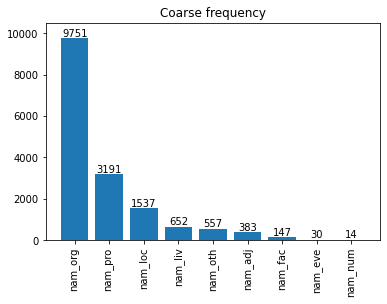

In [26]:
coarse_freq = (entities_df.groupby("coarse").size().sort_values(ascending=False))

bars = plt.bar(coarse_freq.index, coarse_freq.values)

plt.xticks(rotation="vertical")
plt.title("Coarse frequency")
plt.ylim([0, 10500])

for bar in bars:
    height = bar.get_height()
    plt.annotate(str(height), xy=(bar.get_x() + bar.get_width() / 2, height), xytext=(0, 0), textcoords="offset points", ha='center', va='bottom')

# 9. Display 10 most frequent Named Entities for each coarse-grained type.

In [27]:
pd.set_option('display.max_rows', None)

def operation(x):
    return x.groupby(["words", "fine"]).size().nlargest(10)
    
entities_df.groupby("coarse").apply(operation).to_frame('count')

count
coarse  words                               fine                         
nam_adj polski                              nam_adj_country           204
        wojewódzki                          nam_adj_country            20
        europejski                          nam_adj_other              15
        mazowiecki                          nam_adj_other               7
        internetowy                         nam_adj_other               5
        macierzyński                        nam_adj_country             3
        warszawski                          nam_adj_city                3
        afrykański                          nam_adj_country             2
        brzeski                             nam_adj_country             2
        chełmiński                          nam_adj_country             2
nam_eve euro                                nam_eve_human_sport         5
        maksymalny limit pozostałość        nam_eve_human               3
        monitor sądowy                      nam_eve_human_sport         2
        przejściowy plan krajowy            nam_eve_human               2
        II wojna światowy                   nam_eve_other               1
        R5 recykling                        nam_eve_human               1
        X . opieka domowy nad dziecko       nam_eve_human               1
        europejski kart społeczny           nam_eve_human_sport         1
        generalny konserwator zabytek       nam_eve_human               1
        inspektor nadzór wewnętrzny         nam_eve_human               1
nam_fac inspektor nadzór wewnętrzny         nam_fac_goe                50
        komendant główny                    nam_fac_goe                16
        straż graniczny                     nam_fac_goe                13
        mangan                              nam_fac_goe                 8
        obrona narodowy                     nam_fac_goe                 6
        krajowy rejestr karny               nam_fac_goe                 5
        molibden                            nam_fac_goe                 4
        zasłużony dawca przeszczep          nam_fac_goe                 4
        zatoka gdańska                      nam_fac_goe                 4
        MN                                  nam_fac_goe                 3
nam_liv kasa chora                          nam_liv_person            109
        Pan                                 nam_liv_god                38
        straż graniczny                     nam_liv_person             36
        krajowy depozyt                     nam_liv_person             25
        siła zbrojny                        nam_liv_person             24
        Art                                 nam_liv_person             18
        gospodarka żywnościowy              nam_liv_person             16
        główny inspektor                    nam_liv_person             16
        najwyższy                           nam_liv_person             13
        główny lekarz weterynaria           nam_liv_person             11
nam_loc rzeczpospolita polski               nam_loc_gpe_country       812
        Rzeczpospolita Polska               nam_loc_gpe_country        91
        Polska                              nam_loc_gpe_country        72
        Warszawa                            nam_loc_gpe_city           70
        nawóz                               nam_loc_gpe_city           28
        konfederacja szwajcarski            nam_loc_gpe_country        14
        rejestr                             nam_loc_gpe_city            8
        Londyn                              nam_loc_gpe_city            7
        mazowiecki                          nam_loc_gpe_admin1          7
        Bruksela                            nam_loc_gpe_city            6
nam_num 1                                   nam_num_house              13
        112                                 nam_num_phone               1
nam_org skarb państwo                       nam_org_institution       41

# 10. Display 50 most frequent Named Entities including their count and fine-grained type.

In [28]:
pd.set_option('display.max_rows', 50)

entities_df.groupby(["words", "fine"]).size().nlargest(50).to_frame("count")

,,count
words,fine,
Dzieje_(Apostolskie) . u .,nam_pro_media_periodic,1097
rzeczpospolita polski,nam_loc_gpe_country,812
dziennik . u .,nam_pro_media_periodic,438
skarb państwo,nam_org_institution,410
złoty,nam_oth_currency,334
minister sprawiedliwość,nam_org_institution,322
unia europejski,nam_org_organization,296
minister obrona narodowy,nam_org_institution,287
rada minister,nam_org_institution,279


# 11. Display 5 sentences containing at least 2 recognized named entities with different types. Highlight the recognized spans with color. (For demo application Streamlit might be useful for displaying NER results).

In [29]:
pd.set_option('display.max_rows', None)
ss = pd.concat(g for _, g in entities_df.groupby("sentence") if len(g) > 1).sort_values(by=['classes', 'sentence'], ascending=False)

In [30]:
print("Zdanie 1")
print()
print(ss.loc[254].words)
print(ss.loc[255].words)
print(ss.loc[256].words)
print()
print(ss.loc[256].colored[1:]) # 254 - 256


Zdanie 1

wojewódzki
państwowy inspekcja ochrona środowisko
Dzieje_(Apostolskie) . u .

Wójt, burmistrz (prezydent miasta) bądź starosta występują do wojewódzkiego inspektora ochrony środowiska o podjęcie odpowiednich działań, jeżeli powstaje podejrzenie, co do naruszenia przez kontrolowany podmiot przepisów o ochronie środowiska, wynikających z przepisu art. 13 ustawy z dnia 20 lipca 1991 r. o Państwowej Inspekcji Ochrony Środowiska (Dz. U. Nr 77, poz. 335, z 1996 r.


In [31]:
print("Zdanie 2")
print()
print(ss.loc[400].words)
print(ss.loc[401].words)
print(ss.loc[402].words)
print(ss.loc[403].words)
print(ss.loc[404].words)
print()
print(ss.loc[400].colored) # 400 - 404

Zdanie 2

główny geodeta kraj
geodeta kraj
centralne fundusz gospodarka zasób geodezyjny
kartograficzny
rzeczpospolita polski

 Główny Geodeta Kraju wykonuje zadania określone w ustawie, a w szczególności: 1) pełni funkcję organu wyższego stopnia w rozumieniu Kodeksu postępowania administracyjnego w stosunku do wojewódzkich inspektorów nadzoru geodezyjnego i kartograficznego, a także nadzoruje i kontroluje ich działania, 2) prowadzi centralny zasób geodezyjny i kartograficzny oraz dysponuje środkami Centralnego Funduszu Gospodarki Zasobem Geodezyjnym i Kartograficznym, 3) zakłada podstawowe osnowy geodezyjne, grawimetryczne i magnetyczne, 4) opracowuje zasady przygotowania organizacyjno- technicznego katastru, uzgadniania usytuowania projektowanych sieci uzbrojenia terenu oraz wytyczne powszechnej taksacji nieruchomości, 5) prowadzi państwowy rejestr granic Rzeczypospolitej Polskiej oraz granic administracyjnych województw, 6) rejestruje systemy informacji o terenie o znaczeniu ogólnop

In [32]:
print("Zdanie 3")
print()
print(ss.loc[617].words)
print(ss.loc[618].words)
print()
print(ss.loc[617].colored[1:]) # 617 - 618

Zdanie 3

związek ochotniczy straż pożarny
rzeczpospolita polski

wojewódzkim Związku Ochotniczych Straży Pożarnych Rzeczypospolitej Polskiej."; 10) art. 13 otrzymuje brzmienie:" Art. 13.


In [33]:
print("Zdanie 4")
print()
print(ss.loc[53].words)
print(ss.loc[54].words)
print(ss.loc[55].words)
print()
print(ss.loc[54].colored[1:]) # 53 - 55

Zdanie 4

główny inspektor
prezes rad minister
główny inspektor

Zastępcę Głównego Inspektora powołuje i odwołuje Prezes Rady Ministrów na wniosek Głównego Inspektora.


In [34]:
print("Zdanie 5")
print()
print(ss.loc[1141].words)
print(ss.loc[1142].words)
print(ss.loc[1143].words)
print()
print(ss.loc[1141].colored) # 1141 - 1143

Zdanie 5

prezes rad minister
dziennik ustawa
rzeczpospolita polski

 Prezes Rady Ministrów lub minister ogłosi w Dzienniku Ustaw Rzeczypospolitej Polskiej jednolite teksty ustaw, o których mowa w art. 14, 15, 18, 19, 23, 27, 33, 36, 47, 50- 53, 60, 61, 62, 64, 74- 76, 78, 82, 86, 90, 91, 97, 107, 126, 137, 139 z uwzględnieniem zmian wynikających z przepisów ogłoszonych przed dniem wydania jednolitych tekstów ustaw.


# 12. Answer the following questions:

- Which of the method (counting expressions with capital letters vs. NER) worked better for the task concerned with identification of the proper names?
Zliaczanie słów z wielkiej litery daje wymierne wyniki tylko dla nazw własnych które są długie ale nie skłądają się z wielu członów. NER działa tutaj dużo lepiej, bo zliczanie wyrazów w bardzo wielu przypadkach zwraca praktycznie zwykłe słowa które nie są nazwami własnymi, a być może omyłkowo zostały zapisane z wielkiej litery. NER też się myli ale znacznie rzadziej.
- What are the drawbacks of the method based on capital letters?
Przede wszystkim pomijane są początki zdań co sprawia że wiele wyników nie jest branych pod uwagę.
Dodatkowo nie radzi sobie kompletnie z nazwami własnymi zawierającymi np. znaki interpunkcyjne oraz elementy z nazwy ale będące zapisane małymi literami.
Wyciąga wszystkie skróty jako nazwy, a być moze to pomyłki albo nie nazwy.
- What are the drawbacks of the method based on NER?
Pomijam czas jaki jest potrzebny na przetworzenie...
NER wyciąga czasami słowa jako nazwy, które nawet nie zaczynają się z wielkich liter. 
NER też dość niejednoznacznie określa nazwy, bo potrafi jednej nazwie własnej przypisać trzy różne klasy.
- Which of the coarse-grained NER groups has the best and which has the worst results? Try to justify this observation.
bazując na najpopularniejszych 10 wynikach z badanych dokumentów to:
5/10 nam_adj - wyniki są raczej słabe. Kraje jako takie jak polski czy afrykański znajduje poprawnie, ale już przymiotniki od nazw lokalizacji, miast czy większych zrzeszeń (europejski) odnajduje w większości błędnie.
3/10 nam_eve - wyniki dla wydarzeń robionych przez ludzi są złe, właściwie to 2 może 3 wyniki są poprawne, reszta to właściwie nazwy organizacji czy produktów.
2/10 nam_fac - wyniki dla budynków - jest równie źle co w nam_eve. tylko 1 może 2 elementy są poprawne, reszta to nazwy organizacji i produktów.
1/10 nam_liv - wyniki dla ludzi - właściwie nic nie jest tu dobrze. Chyba że liczymy np. "Główny lekarz wterynarii", to może 1 - 2. Ale to też kwestia korpusu z którego było korzystane.
7/10 nam_loc - wyniki dla nazw geograficznych - w sumie to zalicza się tu lokacje w naturze oraz miasta i państwa. To jest całkiem dobry wynik. Bo 6 z 10 jest poprawnych, a od biedy 7. Znajduje kraje i miasta. Lokacji naturalnych raczej tu nie ma.
?/10 nam_num - wyniki dla numerów - ciężko określic, bo są tylko 2 wpisy. "1" oraz "112".
10/10 nam_org - wyniki dla nazw organizacji i instytucji - to jest najlepsza praktycznie kategoria. Wszystko co tutaj się znajduje wydaje mi się poprawne.
0/10 nam_oth - inne - tu wpada wszystko co nie trafiło do pozostąłych. Właściwie to jest tu zbiór byle czego. Są elementy które nie są poprawne, są nazwy pisane wielkimi literami w pełni, są wyrazy które się tu znalazły bóg wiec czemu. Niestety są też tu nazwy które powiny być w innych grupach.
5/10 nam_pro - wyniki dla produktów - sporo jest dobrych wyników, któe wskazują na faktyczne przedmioty które znamy, jednakże połowa wyników to rozwinięte skróty które tu nie pasują i trafiają się elementy z innych grup.
- Do you think NER is sufficient for identifying different occurrences of the same entity (i.e. consider "USA" and "Stany Zjednoczone" and "Stany Zjednoczone Ameryki Północnej")? If not, can you suggest an algorithm or a tool that would be able to group such names together?
Jeżeli nie ma lepszego narzędzia to można wykorzystać NER, ale... on zwraca wyniki w postaci podstawowej przez co dostajemy np. "stan zjednoczony" - przy takich w zyciu nie odgadniemy o co chodziło. Ponadto NER daje wielokrotne wyniki co może być problematyczne np. "stan zjednoczony" oraz "ameryka północna" osobno.
Do poprawy tych wyników można skorzystać z gotowego słownika i szukać w nim podobnych nazw np. odległością levensteina lub po prostu nazw (np. Morfeusz?). Można też użyć słownika synonimów.
- Can you think of a real world problem that would benefit the most from application of Named Entity Recognition algorithm?
Były 2 wspomniane na wykładzie - odnośniki do wikipedii + spis treści w książce (właściwie to było o skorowidzu)
